<a href="https://colab.research.google.com/github/ApssaraGanesh/AIML_CODEBASE/blob/main/GPT2_TASK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# import zipfile

# #Replace 'your_uploaded_file.zip' with the actual filename
# zip_file_name = '/content/drive/MyDrive/qa dataset/aiml-qa-dataset.zip'
# with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
#     zip_ref.extractall('/content/drive/MyDrive/Capstone/qa dataset')

In [1]:
!pip install evaluate sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 872.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 4.6 MB/s eta 0:00:00


In [2]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=77388e08aeece63c398efd23d6173052c454767e3d30453e9f7c5ea4a2b29414
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [4]:
!pip install transformers accelerate

In [5]:
import os
import math
import random
import torch
import evaluate
import numpy as np
import pandas as pd
import  seaborn as sns
from matplotlib import pyplot as plt


from transformers import LineByLineTextDataset
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer,GPT2LMHeadModel
from transformers import Trainer,TrainingArguments

2024-02-03 14:49:24.938388: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 14:49:24.938480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 14:49:25.099309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [9]:
import wandb
wandb.login(key = 'd2ad0a7285379c0808ca816971d965fc242d0b5e')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
# import wandb

run =wandb.init(project = "Question_Answer_final", id='sh7a1v6g', resume='must')

wandb: Currently logged in as: adarshj322. Use `wandb login --relogin` to force relogin


In [11]:
DOWN_DATA_PATH = 'aiml-qa-dataset'
LINES_DATA_PATH = 'q&a_dataset'
MODEL_KEY = 'distilgpt2'
EXP_NAME = f'qa-subgen-{MODEL_KEY}'


SEED_VALUE = 15
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 2
EVAL_BATCH_SIZE = 2 * TRAIN_BATCH_SIZE
N_EPOCHS = 1

In [12]:
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)

In [13]:
import re

In [29]:
%cd /kaggle/working/

/kaggle/working


In [28]:
!ls

Q_test_data.csv  train_data.csv  val_data.csv


In [23]:
!pwd

/kaggle/input


In [31]:
df = pd.read_csv('/kaggle/input/train_data.csv') 

In [32]:
df.isnull().values.sum()


0

In [33]:

def clean_text(text):
    # Lowercase the text
    
    res = re.sub(r'\d', '', text)

    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W', ' ', text)
    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [34]:
os.makedirs(LINES_DATA_PATH, exist_ok=True)

def prepare_train_dataset(down_data_path, lines_data_path, split):
    # Read data from the XLSX file into a pandas DataFrame
    data = pd.read_csv('/kaggle/input/train_data.csv')
    data = data.dropna()

    # Create the output file path with the split name and .txt extension
    output_file = os.path.join(lines_data_path, f'{split}.txt')

    # Open the output text file in write mode
    with open(output_file, 'w') as f:
        # Iterate through each row in the DataFrame
        for index, row in data.iterrows():
            question = row['Q']
            answer = row['A']
            mq = row['MQ']
            ma = row['MA']
            
            question = clean_text(question)
            answer = clean_text(answer)
            mq = clean_text(mq)
            ma = clean_text(ma)

            # Write the question and answer in the desired format to the text file
            f.write(f"<question> {question}<answer> {answer}\n<question> {mq}<answer> {ma}\n")

# Replace 'DOWN_DATA_PATH' with the path to your input XLSX file
#DOWN_DATA_PATH = "path/to/your/input_file.xlsx"

# Replace 'LINES_DATA_PATH' with the path to your lines data directory
#LINES_DATA_PATH = "path/to/your/lines_data_directory"

# Replace 'qatrain' with the desired split name
prepare_train_dataset(DOWN_DATA_PATH, LINES_DATA_PATH, 'qatrain')


In [36]:
os.makedirs(LINES_DATA_PATH, exist_ok=True)

def prepare_dev_dataset(down_data_path, lines_data_path, split):
    # Read data from the XLSX file into a pandas DataFrame
    data = pd.read_csv('/kaggle/input/val_data.csv')

    # Create the output file path with the split name and .txt extension
    output_file = os.path.join(lines_data_path, f'{split}.txt')

    # Open the output text file in write mode
    with open(output_file, 'w') as f:
        # Iterate through each row in the DataFrame
        for index, row in data.iterrows():
            
            question = row['Q']
            answer = row['A']
            mq = row['MQ']
            ma = row['MA']
            
            question = clean_text(question)
            answer = clean_text(answer)
            mq = clean_text(mq)
            ma = clean_text(ma)

            # Write the question and answer in the desired format to the text file
            f.write(f"<question> {question}<answer> {answer}\n<question> {mq}<answer> {ma}\n")


# Replace 'DOWN_DATA_PATH' with the path to your input XLSX file
#DOWN_DATA_PATH = "path/to/your/input_file.xlsx"

# Replace 'LINES_DATA_PATH' with the path to your lines data directory
#LINES_DATA_PATH = "path/to/your/lines_data_directory"

# Replace 'qatrain' with the desired split name
prepare_dev_dataset(DOWN_DATA_PATH, LINES_DATA_PATH, 'qadev')

In [37]:
os.makedirs(LINES_DATA_PATH, exist_ok=True)

def prepare_test_dataset(down_data_path, lines_data_path, split):
    # Read data from the XLSX file into a pandas DataFrame
    data = pd.read_csv('/kaggle/input/Q_test_data.csv')

    # Create the output file path with the split name and .txt extension
    output_file = os.path.join(lines_data_path, f'{split}.txt')

    # Open the output text file in write mode
    with open(output_file, 'w') as f:
        # Iterate through each row in the DataFrame
        for index, row in data.iterrows():
            question = row['Q']
            
            question = clean_text(question)
            
            # Write the question and answer in the desired format to the text file
            f.write(f"<question> {question}<answer> \n")

# Replace 'DOWN_DATA_PATH' with the path to your input XLSX file
#DOWN_DATA_PATH = "path/to/your/input_file.xlsx"

# Replace 'LINES_DATA_PATH' with the path to your lines data directory
#LINES_DATA_PATH = "path/to/your/lines_data_directory"

# Replace 'qatrain' with the desired split name
prepare_test_dataset(DOWN_DATA_PATH, LINES_DATA_PATH, 'qatest')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


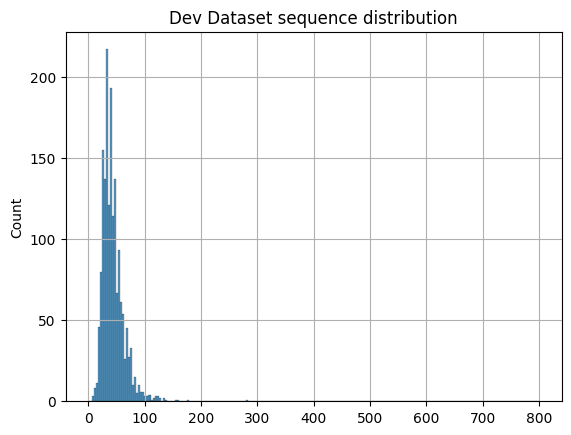

In [38]:
with open(os.path.join(LINES_DATA_PATH,'qatrain.txt'),'r') as f:
    dev_lines = f.readlines()
dev_seq_lens = np.array([len(line.split()) for line in dev_lines])
sns.histplot(dev_seq_lens,binrange=(0,800))
plt.grid()
plt.title('Dev Dataset sequence distribution')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


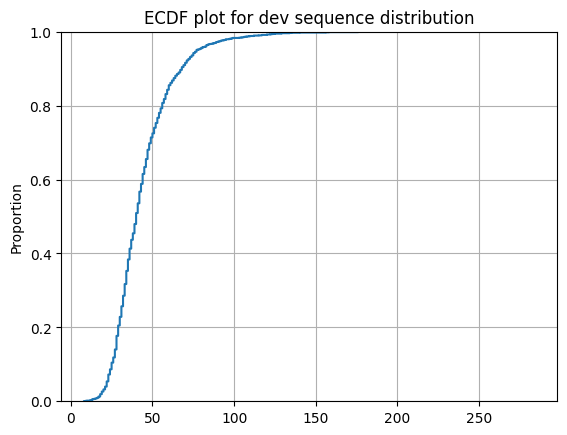

In [39]:
sns.ecdfplot(np.clip(dev_seq_lens,a_min=0,a_max=800))
plt.grid()
plt.title('ECDF plot for dev sequence distribution')
plt.show()

In [ ]:
dev_seq_lens.mean(),dev_seq_lens.std(),np.median(dev_seq_lens),dev_seq_lens.min(),dev_seq_lens.max()

In [40]:
def load_dataset(file_path,tokenizer):
    block_size = 256 if 'train' in file_path else 512

    dataset = LineByLineTextDataset(
             tokenizer=tokenizer,
             file_path=file_path,
             block_size=block_size
    )
    return dataset

In [41]:
def load_data_collator(tokenizer,mlm=False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm
    )
    return data_collator

In [42]:
tokenizer= GPT2Tokenizer.from_pretrained(MODEL_KEY)
tokenizer.add_special_tokens({'pad_token':'{PAD}'})

model = GPT2LMHeadModel.from_pretrained(MODEL_KEY)
model.resize_token_embeddings(len(tokenizer))

type(tokenizer),type(model)

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

(transformers.models.gpt2.tokenization_gpt2.GPT2Tokenizer,
 transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel)

In [43]:
n_model_params = 0
for p in model.parameters():
    n_model_params += p.numel()

print(f' *parameters in LM Head Model {MODEL_KEY}:{n_model_params}')

 *parameters in LM Head Model distilgpt2:81913344


In [45]:
train_dataset=load_dataset(os.path.join(LINES_DATA_PATH,'qatrain.txt'),tokenizer)
dev_dataset=load_dataset(os.path.join(LINES_DATA_PATH,'qadev.txt'),tokenizer)
test_dataset=load_dataset(os.path.join(LINES_DATA_PATH,'qatest.txt'),tokenizer)


In [46]:
data_collator=load_data_collator(tokenizer)

In [47]:

len(train_dataset),len(dev_dataset), len(test_dataset)

(1712, 192, 239)

In [48]:
pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 837.7 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [50]:
from evaluate import load

In [51]:
bleu = evaluate.load('bleu')
rouge = evaluate.load('rouge')
bertscore = load('bertscore')
#meteor = evaluate.load('meteor')


def preprocess_logits_for_metrics(logits, labels):
    pred_ids = torch.argmax(logits, dim=-1)

    return pred_ids, labels


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = logits[0]
    preds = np.where(preds!= -100,preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    sequences = tokenizer.batch_decode(labels, skip_special_tokens=True)

    prompts = list()
    references = list()
    for sequence in sequences:
        try:
            prompt, ref_text = sequence.split('<answer> ')
            prompt += '<answer> '
            #answer1, answer1_right = ref_text.split('<answer2>')
            #answer2, answer2_right = answer1_right.split('<ann1>')
            prompts.append(prompt)
            references.append([ref_text])
        except ValueError:
            continue

    tokenizer.padding_side='left'
    n_batches = math.ceil(len(prompts)*1.0 / EVAL_BATCH_SIZE)
    outputs = list()
    for i in range(n_batches):
        prompts_batch = prompts[i*EVAL_BATCH_SIZE : (i+1)*EVAL_BATCH_SIZE]
        prompts_batch_ids = tokenizer(prompts_batch,
            padding=True, truncation=True, return_tensors='pt').to(model.device)
        output_ids = model.generate(
            **prompts_batch_ids, max_new_tokens=50,
            pad_token_id=tokenizer.pad_token_id)
        outputs_batch = [seq.split('<answer>')[1] for seq in
            tokenizer.batch_decode(output_ids, skip_special_tokens=True)]
        outputs.extend(outputs_batch)
    tokenizer.padding_side='right'

    bleu_score = bleu.compute(predictions=outputs, references=references)
    rouge_score = rouge.compute(predictions=outputs, references=references)
    results = bertscore.compute(predictions=outputs, references=references,lang='en')
    avg_precision = sum(results['precision']) / len(results['precision'])
    avg_recall = sum(results['recall']) / len(results['recall'])
    avg_f1 = sum(results['f1']) / len(results['f1'])
    #f1_score = lambda predictions, references: (2 * sum((collections.Counter(predictions) & collections.Counter(references)).values()) / (len(predictions) + len(references))) if (num_same := sum((collections.Counter(predictions) & collections.Counter(references)).values())) != 0 else 0
    #average_f1 = sum(f1_score) / len(f1_score)
    #meteor_score = meteor.compute(predictions=outputs, references=references)

    wandb.log({
        'BLEU': round(bleu_score['bleu'], 4) * 100,
        'R1': round(rouge_score['rouge1'], 4) * 100,
        'R2': round(rouge_score['rouge2'], 4) * 100,
        'RL': round(rouge_score['rougeL'], 4) * 100,
        'RLsum': round(rouge_score['rougeLsum'], 4) * 100,
        'PRECISION': round(avg_precision,2) * 100,
        'RECALL': round(avg_recall,2) * 100,
        'F1_SCORE' : round(avg_f1,2) * 100
    })
    return {
        'BLEU': round(bleu_score['bleu'], 4) * 100,
        'R1': round(rouge_score['rouge1'], 4) * 100,
        'R2': round(rouge_score['rouge2'], 4) * 100,
        'RL': round(rouge_score['rougeL'], 4) * 100,
        'RLsum': round(rouge_score['rougeLsum'], 4) * 100,
        'PRECISION': round(avg_precision,2) * 100,
        'RECALL': round(avg_recall,2) * 100,
        'F1_SCORE' : round(avg_f1,2) * 100
        #'F1_SCORE' : round(average_f1, 4) * 100
        #'METEOR': round(meteor_score['meteor'], 4) * 100
        }

In [52]:
last_run_id = 'sh7a1v6g'
my_checkpoint_name = f"checkpoint-{last_run_id}:v19"
my_checkpoint_artifact = run.use_artifact(my_checkpoint_name)
checkpoint_dir = my_checkpoint_artifact.download()
#base_model = AutoModelForCausalLM.from_pretrained('/kaggle/working/artifacts/checkpoint-jxdoo6gc:v6', quantization_config=bnb_config,device_map={"": 0})

wandb: Downloading large artifact checkpoint-sh7a1v6g:v19, 937.53MB. 8 files... 
wandb:   8 of 8 files downloaded.  
Done. 0:0:5.1


In [53]:
import os
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [54]:

training_args = TrainingArguments(
          output_dir=EXP_NAME,
          overwrite_output_dir=True,
          evaluation_strategy = 'steps',
          weight_decay=0.01,
          eval_steps = 100,
          max_steps = 5000,
          learning_rate=LEARNING_RATE,
          gradient_accumulation_steps=2,
          warmup_steps=1000,
          save_strategy = 'epoch',
          per_device_train_batch_size=TRAIN_BATCH_SIZE,
          per_device_eval_batch_size=EVAL_BATCH_SIZE,
          num_train_epochs=N_EPOCHS,
          report_to="wandb",
          fp16=True
      )

trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
          eval_dataset=dev_dataset,
          preprocess_logits_for_metrics=preprocess_logits_for_metrics,
          compute_metrics=compute_metrics
          )
trainer.train(resume_from_checkpoint='/kaggle/working/artifacts/checkpoint-sh7a1v6g:v19')
trainer.save_model()


You are resuming training from a checkpoint trained with 4.36.0 of Transformers but your current version is 4.37.0. This is not recommended and could yield to errors or unwanted behaviors.
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Bleu,R1,R2,Rl,Rlsum,Precision,Recall,F1 Score
4300,0.609100,4.200174,3.370000,21.830000,5.410000,15.930000,15.930000,82.000000,84.000000,83.000000
4400,0.609100,4.214696,2.990000,20.890000,5.110000,15.410000,15.410000,83.000000,84.000000,83.000000
4500,0.515400,4.212700,2.980000,20.990000,4.930000,15.210000,15.220000,82.000000,84.000000,83.000000
4600,0.515400,4.234282,2.690000,22.130000,5.200000,15.750000,15.760000,82.000000,85.000000,83.000000
4700,0.515400,4.238164,2.960000,21.080000,4.850000,15.090000,15.090000,83.000000,84.000000,83.000000
4800,0.515400,4.242107,2.740000,20.830000,4.780000,14.870000,14.870000,82.000000,84.000000,83.000000
4900,0.515400,4.242385,2.430000,21.150000,4.470000,15.090000,15.080000,82.000000,84.000000,83.000000
5000,0.484500,4.245282,2.560000,21.580000,4.800000,15.530000,15.510000,83.000000,84.000000,83.000000


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Adding directory to artifact (./qa-subgen-distilgpt2/checkpoint-4494)... Done. 2.9s
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
wandb: Adding directory to artifact (./qa-subgen-distilgpt2/checkpoint-4708)... Done. 2.8s
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along d

In [ ]:
import shutil
shutil.make_archive('QandAmodel', 'zip', 'qa-subgen-distilgpt2')

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [ ]:
artifact = wandb.Artifact('final_model_QA', type='model')
artifact.add_dir('qa-subgen-distilgpt2')

run.log_artifact(artifact)
run.finish()